In [1]:
# using ProgressMeter
using Flux, Statistics, StatsBase, GraphNeuralNetworks, Graphs, MLUtils, Plots #, CUDA
using Flux.Data: DataLoader
using GraphMakie, CairoMakie
using Trapz, Printf
using UnROOT #Julia native package for reading root files
import Interpolations
using Random
using Glob
using BSON

In [2]:
include("lundplane_utils.jl")

load_chunk_from_rootfiles (generic function with 2 methods)

In [3]:
model_name = "model_bsons/myGNN_6LPfeats_v3_11"

BSON.@load "$(model_name).bson" model

In [4]:
gl_sig = "../lundNtuples_20210322/user.asopio.grid_wprime*_ANALYSIS.root/*"
gl_bkg = "../lundNtuples_20210322/user.asopio.grid_dijet*_ANALYSIS.root/*"

test_graphs = GNNGraph[]
nch = 50

for ich in 1:nch
    println("Making test graphs for chunk ",ich,)
    sig_samples = load_chunk_from_rootfiles( gl_sig, nch, ich, 1.0 )
    bkg_samples = load_chunk_from_rootfiles( gl_bkg, nch, ich, 0.0 )

    all_samples = GNNGraph[]
    append!( all_samples, sig_samples )
    append!( all_samples, bkg_samples )
    
    Random.seed!(1234)
    train_graphs_ch, test_graphs_ch = MLUtils.splitobs(all_samples, at=0.99, shuffle=true)
    append!( test_graphs, test_graphs_ch )
    
end

Making test graphs for chunk 1
Making test graphs for chunk 2
Making test graphs for chunk 3
Making test graphs for chunk 4
Making test graphs for chunk 5
Making test graphs for chunk 6
Making test graphs for chunk 7
Making test graphs for chunk 8
Making test graphs for chunk 9
Making test graphs for chunk 10
Making test graphs for chunk 11
Making test graphs for chunk 12
Making test graphs for chunk 13
Making test graphs for chunk 14
Making test graphs for chunk 15
Making test graphs for chunk 16
Making test graphs for chunk 17
Making test graphs for chunk 18
Making test graphs for chunk 19
Making test graphs for chunk 20
Making test graphs for chunk 21
Making test graphs for chunk 22
Making test graphs for chunk 23
Making test graphs for chunk 24
Making test graphs for chunk 25
Making test graphs for chunk 26
Making test graphs for chunk 27
Making test graphs for chunk 28
Making test graphs for chunk 29
Making test graphs for chunk 30
Making test graphs for chunk 31
Making test graph

In [5]:
#Evaluate performance 
test_scores = Float32[]
test_truth = Float32[]
test_pt = Float32[]
test_m = Float32[]

sig_scores = Float32[]
bkg_scores = Float32[]

tag_sig_pt = Float32[]
untag_sig_pt = Float32[]
tag_bkg_pt = Float32[]
untag_bkg_pt = Float32[]

tag_cut = 0.9

let model = cpu(model) #Not sure how to do inference on GPU yet...
    for tgr in test_graphs
        push!( test_truth, tgr.gdata.y )
        push!( test_pt, tgr.gdata.pt )
        push!( test_m, tgr.gdata.m )
        
        ypred = model( tgr, tgr.ndata.x )[1]
        push!( test_scores, ypred )

        pt = tgr.gdata.pt
        
        if tgr.gdata.y == 1.0
            push!( sig_scores, ypred )
            if ypred > tag_cut
                push!( tag_sig_pt, pt )
            else
                push!( untag_sig_pt, pt )
            end
        else
            push!( bkg_scores, ypred )
            if ypred > tag_cut
                push!( tag_bkg_pt, pt )
            else
                push!( untag_bkg_pt, pt )
            end
        end
    end
end 

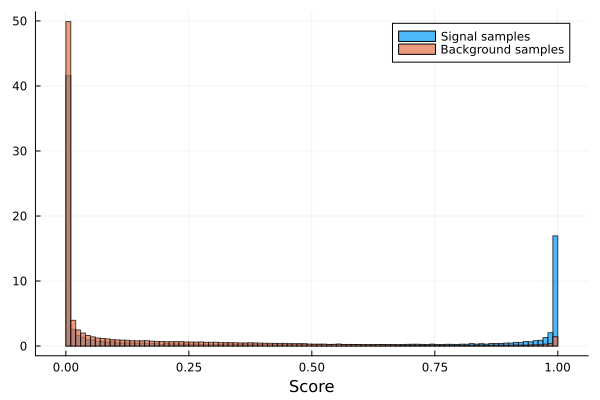

In [6]:
bw = 0.01

histogram(sig_scores,bins=0:bw:1.0,label="Signal samples", xlabel="Score",alpha=0.7,norm=true)
histogram!(bkg_scores,bins=0:bw:1.0,label="Background samples",alpha=0.7,norm=true)

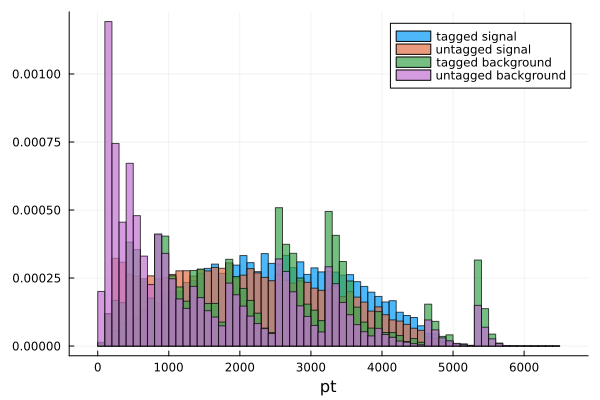

In [7]:
ptbw = 100
hbins = 0:ptbw:6500.0

histogram(tag_sig_pt,bins=hbins,label="tagged signal", xlabel="pt",alpha=0.7,norm=true)
histogram!(untag_sig_pt,bins=hbins,label="untagged signal",alpha=0.7,norm=true)
histogram!(tag_bkg_pt,bins=hbins,label="tagged background",alpha=0.7,norm=true)
histogram!(untag_bkg_pt,bins=hbins,label="untagged background",alpha=0.7,norm=true)

In [8]:
ptbins = 0:ptbw:6000.0

h_pt_tag_sig = fit( Histogram, tag_sig_pt, ptbins ).weights
h_pt_untag_sig = fit( Histogram, untag_sig_pt, ptbins ).weights
h_pt_tag_bkg = fit( Histogram, tag_bkg_pt, ptbins ).weights
h_pt_untag_bkg = fit( Histogram, untag_bkg_pt, ptbins ).weights

60-element Vector{Int64}:
  2068
 12287
  7672
  4690
  6919
  4938
  3406
  2328
  4245
  3509
  2548
  1783
  1428
     ⋮
   308
   201
   101
    49
    18
  1541
   713
   274
    91
    22
    12
     2

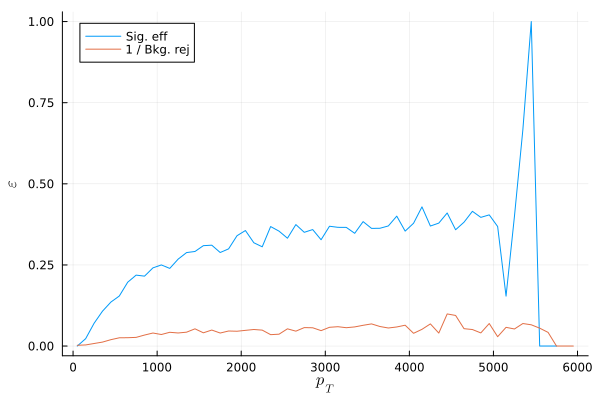

In [9]:
ptbincs = [ 0.5*(ptbins[ib]+ptbins[ib+1]) for ib in 1:length(ptbins)-1 ]

Plots.plot( ptbincs, h_pt_tag_sig ./ (h_pt_tag_sig + h_pt_untag_sig), xlabel=L"p_T", ylabel=L"\epsilon", label="Sig. eff" )
Plots.plot!( ptbincs, h_pt_tag_bkg ./ (h_pt_tag_bkg + h_pt_untag_bkg), label="1 / Bkg. rej" )

In [10]:
struct ROC
    tprs 
    fprs 
    auc
    fpr_itp
    tpr_itp
    function ROC( sc_sig, sc_bkg; bwidth=0.001 )
    
        bins = 0:0.001:1.0
        bincs = [ 0.5*(bins[i] + bins[i+1]) for i in 1:length(bins)-1 ]
    
        sigscores = fit(Histogram, sc_sig, bins).weights
        sigscores = sigscores / sum(sigscores)
#         sigscores = sigscores / trapz( bincs, sigscores )
    
        bkgscores = fit(Histogram, sc_bkg, bins).weights
        bkgscores = bkgscores / sum(bkgscores)
#         bkgscores = bkgscores / trapz( bincs, bkgscores )

        tprs = [ 1.0 ]
        fprs = [ 1.0 ]

        tprs = append!(tprs, [ sum(sigscores[i:end]) for i in 1:length(sigscores) ])
        fprs = append!(fprs, [ sum(bkgscores[i:end]) for i in 1:length(bkgscores) ])
    
        tprs = append!(tprs, [ 0.0 ])
        fprs = append!(fprs, [ 0.0 ])
    
        reverse!( fprs ) #reverse so that both start at 0.0
        reverse!( tprs ) 
    
        auc = trapz(fprs, tprs)
    
        fpr_itp = Interpolations.linear_interpolation( Interpolations.deduplicate_knots!(tprs,move_knots=true), fprs )
        tpr_itp = Interpolations.linear_interpolation( Interpolations.deduplicate_knots!(fprs,move_knots=true), tprs )
        new(tprs,fprs,auc,fpr_itp,tpr_itp)
    end

#     function rej_at_tpr( tpr )
end

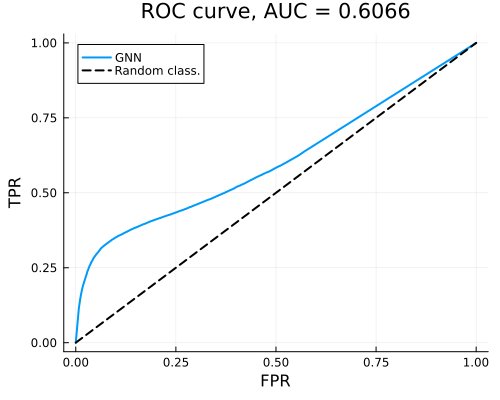

In [11]:
#Plot a ROC curve
roc = ROC( sig_scores, bkg_scores )

Plots.plot( roc.fprs, roc.tprs, title="ROC curve, AUC = $(@sprintf("%.4f", roc.auc))", 
                        xlabel="FPR", ylabel="TPR", linewidth=2, label="GNN", size=(500,400) )
Plots.plot!( [0,1], [0,1], color="black", linestyle=:dash, linewidth=2, label="Random class." )

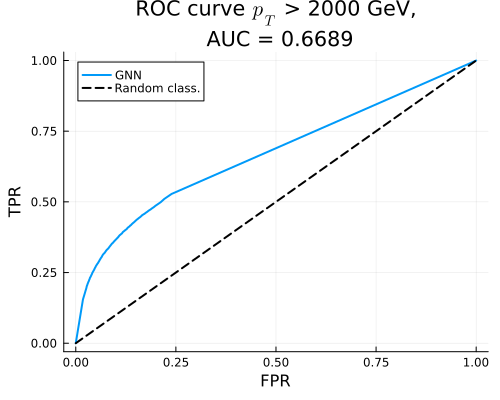

In [12]:
ptmin = 2000
sig_sc_ptmin = [ sc for (i, sc) in enumerate(test_scores) if ( test_pt[i] > ptmin )&&( test_truth[i]>0.5 ) ]
bkg_sc_ptmin = [ sc for (i, sc) in enumerate(test_scores) if ( test_pt[i] > ptmin )&&( test_truth[i]<0.5 ) ]

roc = ROC( sig_sc_ptmin, bkg_sc_ptmin )
Plots.plot( roc.fprs, roc.tprs, title="ROC curve $(L"p_T") > $(@sprintf("%.0f", ptmin)) GeV,\n AUC = $(@sprintf("%.4f", roc.auc))", 
                        xlabel="FPR", ylabel="TPR", linewidth=2, label="GNN", size=(500,400) )
Plots.plot!( [0,1], [0,1], color="black", linestyle=:dash, linewidth=2, label="Random class." )

In [13]:
ptbins = 0:500:6000.0

aucs = Float32[]

bkg_rej50 = Float32[]
bkg_rej80 = Float32[]

for (ptmin,ptmax) in zip(ptbins[1:end-1],ptbins[2:end]) 
    sig_sc_ptbin = [ sc for (i, sc) in enumerate(test_scores) if ( ptmin < test_pt[i] < ptmax )&&( test_truth[i]>0.5 ) ]
    bkg_sc_ptbin = [ sc for (i, sc) in enumerate(test_scores) if ( ptmin < test_pt[i] < ptmax )&&( test_truth[i]<0.5 ) ]

    roc = ROC(sig_sc_ptbin,bkg_sc_ptbin)
    
    push!(aucs, roc.auc)
    push!(bkg_rej50, 1/roc.fpr_itp(0.5))
    push!(bkg_rej80, 1/roc.fpr_itp(0.8))
    
end


mbins = 0:20:600.0

aucs_m = Float32[]

bkg_rej50_m = Float32[]
bkg_rej80_m = Float32[]

for (mmin,mmax) in zip(mbins[1:end-1],mbins[2:end]) 
    sig_sc_mbin = [ sc for (i, sc) in enumerate(test_scores) if ( mmin < test_m[i] < mmax )&&( test_truth[i]>0.5 ) ]
    bkg_sc_mbin = [ sc for (i, sc) in enumerate(test_scores) if ( mmin < test_m[i] < mmax )&&( test_truth[i]<0.5 ) ]

    roc = ROC(sig_sc_mbin,bkg_sc_mbin)
    
    push!(aucs_m, roc.auc)
    push!(bkg_rej50_m, 1/roc.fpr_itp(0.5))
    push!(bkg_rej80_m, 1/roc.fpr_itp(0.8))
end

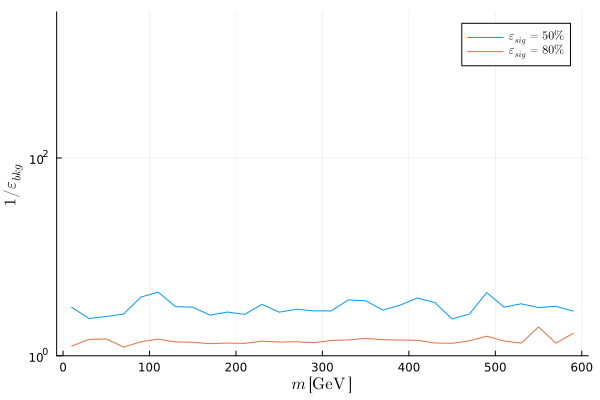

In [14]:
Plots.plot( 0.5*(mbins[1:end-1]+mbins[2:end]), bkg_rej50_m, ylabel=L"1/\epsilon_{bkg}", xlabel=L"m \; \mathrm{[GeV]}", label=L"\epsilon_{sig} = 50\%", yaxis=:log, ylim=[1,3000] )
Plots.plot!( 0.5*(mbins[1:end-1]+mbins[2:end]), bkg_rej80_m, label=L"\epsilon_{sig} = 80\%" )

In [ ]:
# #Plot the graph of an LJP
# f = Figure( resolution = (800, 650) )
# ax1 = Axis(f[1, 1], title="W jet")
# ax2 = Axis(f[2, 1], title="QCD jet")
# ax3 = Axis(f[1, 2], title="")
# ax4 = Axis(f[2, 2], title="")
# ax5 = Axis(f[1, 3], title="")
# ax6 = Axis(f[2, 3], title="")


# plt1 = graphplot!(ax1, sig_samples[idgr] |> to_unidirected; node_size=15, 
#                   node_color=sig_samples[idgr].ndata.x[1,:], arrow_show=false, node_attr=(colorrange=(0,1),) )
# plt2 = graphplot!(ax2, bkg_samples[idgr] |> to_unidirected, node_size=15, 
#                   node_color=bkg_samples[idgr].ndata.x[1,:], arrow_show=false, node_attr=(colorrange=(0,1),))
# plt3 = graphplot!(ax3, sig_samples[idgr] |> to_unidirected, node_size=15, 
#                   node_color=sig_samples[idgr].ndata.x[2,:], arrow_show=false, node_attr=(colorrange=(0,0.5),))
# plt4 = graphplot!(ax4, bkg_samples[idgr] |> to_unidirected, node_size=15, 
#                   node_color=bkg_samples[idgr].ndata.x[2,:], arrow_show=false, node_attr=(colorrange=(0,0.5),))
# plt5 = graphplot!(ax5, sig_samples[idgr] |> to_unidirected, node_size=15, 
#                   node_color=log.(sig_samples[idgr].ndata.x[3,:]), arrow_show=false, node_attr=(colorrange=(-2.5,2.5),))
# plt6 = graphplot!(ax6, bkg_samples[idgr] |> to_unidirected, node_size=15, 
#                   node_color=log.(bkg_samples[idgr].ndata.x[3,:]), arrow_show=false, node_attr=(colorrange=(-2.5,2.5),))


# for ax in [ax1,ax2,ax3,ax4,ax5,ax6] hidedecorations!(ax) end#; hidespines!(ax1)

# max_dr = maximum( [maximum(sig_samples[idgr].ndata.x[1,:]), maximum(bkg_samples[idgr].ndata.x[1,:])] )
# max_z = maximum( [maximum(sig_samples[idgr].ndata.x[2,:]), maximum(bkg_samples[idgr].ndata.x[2,:])] )
# max_kt = maximum( [maximum(log.(sig_samples[idgr].ndata.x[3,:])), maximum(log.(bkg_samples[idgr].ndata.x[3,:]))] )
# min_kt = minimum( [minimum(log.(sig_samples[idgr].ndata.x[3,:])), minimum(log.(bkg_samples[idgr].ndata.x[3,:]))] )

# lim_dr = [0.0, max_dr]
# lim_z = [0.0, max_z]
# lim_kt = [min_kt, max_kt]


# cbar1 = Colorbar(f[3,1], get_node_plot(plt1), label = L"\Delta R", vertical=false, flipaxis = false)
# cbar1.width = Relative(8/9)
# cbar2 = Colorbar(f[3,2], get_node_plot(plt3), label = L"z", vertical=false, flipaxis = false)
# cbar2.width = Relative(8/9)
# cbar3 = Colorbar(f[3,3], get_node_plot(plt5), label = L"\ln(k_T)", vertical=false, flipaxis = false)
# cbar3.width = Relative(8/9)

# f

# save("ljp_graphs_drzkt.pdf",f)